# Standard Layers

We will now see some examples of typical layers in DL.

Usually, layers have a batch axis, although frameworks and usually math take them implicitly.

A [typical neural network](https://dmol.pub/_images/nn.svg) that takes 128x128 images with 3 channels (RGB) and outputs a vector of 128 probabilities that codify the object seen by the NN (cat, vase, crane...).

## 1. Hyperparameters

We saw from the Full connected (FC)/Dense layer that we have to choose if we use bias, the activation, and the output shape. As we learn about more complex layers, there will be more choices. These choices begin to accumulate and in a neural network you may have billions of possible combinations of them. These choices about shape, activation, initialization, and other layer arguments are called hyperparameters. They are parameters in the sense that they can be tuned, but they are not trained on our data so we call them hyperparameters to distinguish them from the “regular” parameters like value of weights and biases in the layers. The name is inherited from Bayesian statistics.

### 1.1. Validation

The number of hyperparameters is high enough that overfitting can actually occur by choosing hyperparameters that minimize error on the test set. This is surprising because we don’t explicitly train hyperparameters. Nevertheless, you will find in your own work that if you use the test data extensively in hyperparameter tuning and for assessing overfitting of the regular training parameters, your performance will be overfit to the testing data. To combat this, we split our data three ways in deep learning:

1. Training data: used for trainable parameters.
2. Validation data: used to choose hyperparameters or measure overfitting of training data
3. Test data: data not used for anything except final reported error

To clean-up our nomenclature here, we use the word generalization error to refer to performance on a hypothetical infinite stream of unseen data. So regardless of if you split three-ways or use other approaches, generalization error means error on unseen data.

## 2. Common Layers

### 2.1. Convolutions

Convolutions are a layer typically used in image processing. Each convolutin layer has a grid $(H,W)$ that takes $H\times W$ pixels from the image and a set of filters $F$ that are trained to produce an output. Adding as well the channels we see that the layer has shape $(C, H, W, F)$.

Convolution Layers are **equivariant**, meaning that if the input (cat) is displaced in the image, the output is displaced as well. Another type of property is **invariance**, where the position of the input is irrelevant to the output.

Another important term is **padding**. If you want a grid of, say (32,32), but your input is (30,30), you can add 2 extra pixels to the sides and top and bottom parts, fill them with 0s, and obtain an image of (32,32).

### 2.2. Pooling

Convolutions are commonly paired with pooling layers because pooling also is translationally equivariant. If your goal is to produce a single number (regression) or class (classification) from an input image or sequence, you need to reduce the rank to 0, a scalar. After a convolution, you could use a reduction like average or maximum. It has been shown empirically that reducing the number of elements of your features more gradually is better. One way is through pooling. Pooling is similar to convolutions, in that you define a kernel shape (called window shape), but pooling has no trainable parameters. Instead, you run a window across your input grid and compute a reduction. Commonly an average or maximum is computed. For example, you might use three rounds of convolutions and pooling to take an image from $32\times 32$ down to a $4\times 4$. Read more about [pooling here](https://d2l.ai/chapter_convolutional-neural-networks/pooling.html).

### 2.2. Embedding

Another important type of input layers are embeddings. Embeddings convert integers into vectors. They are typically used to convert characters or words into numerical vectors. The characters or words are first converted into tokens separately as a pre-processing step and then the input to the embedding layer is the indices of the token. The indices are integer values that index into a dictionary of all possible tokens. It sounds more complex than it is. For example, we might tokenize characters in the alphabet. There are 26 tokens (letters) in the alphabet (dictionary of tokens) and we could convert the word “hello” into the indices [7,4,11,11,14], where 7 means the 7th letter of the alphabet.

After converting into indices, an embedding layer converts these indices into dense vectors of a chosen dimension. The rationale behind embeddings is to go from a large discrete space (e.g., all words in the English language) into a much smaller space of real numbers (e.g., vectors of size 5).

## 3. Example

At this point, we have enough common layers to try to build a neural network. We will combine these three layers to predict if a protein is soluble. Our [dataset](https://pubmed.ncbi.nlm.nih.gov/23926206/) consists of proteins known to be soluble or insoluble. As usual, the code below sets-up our imports.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib
# import dmol

2022-07-06 12:42:34.143824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 12:42:34.143841: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Our task is binary classification. The data is split into two: positive and negative examples. We’ll need to rearrange a little into a normal dataset with labels and training/testing split. We also really really need to shuffle our data, so it doesn’t see all positives and then all negatives.

In [4]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/solubility.npz",
    "solubility.npz",
)
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]


# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(16)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

18453 examples


2022-07-06 12:49:17.554485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 12:49:17.554895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 12:49:17.554938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-06 12:49:17.554976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-06 12:49:17.555014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Before getting to modeling, let’s examine our data. The protein sequences have already been tokenized. There are 20 possible values at each position because there are 20 amino acids possible in proteins. Let’s see a soluble protein

In [12]:
pos_data.shape

(8785, 200)

Notice that integers/indices are used because our data is tokenized already. To make our data all be the same input shape, a special token (0) is inserted at the end indicating no amino acid is present. This needs to be treated carefully, because it should be zeroed throughout the network. Luckily this is built into Keras, so we do not need to worry about it.

This data is perfect for an embedding because we need to convert token indices to real vectors. Then we will use 1D convolutions to look for sequence patterns with pooling. We need to then make sure our final layer is a sigmoid, just like in Classification.

We begin with an embedding. We’ll use a 2-dimensional embedding, which gives us two channels for our sequence. We’ll just choose our kernel filter size for the 1D convolution to be 5 and we’ll use 16 filters. Beyond that, the rest of the network is about distilling gradually into a final class.

In [13]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# INFO FOR EMBEDDING

# input_dim: The size of the tokens on the input + 1. Since aminoacids
# are encoded from 1 to 20 we use input_dim = 21

# output_dim: The dimension that outputs of this layer.

# mask_zero: Indicates that 0 should be ignored because it has no meaning.

# input_length: The size of the vectors (tensors) that we are inputting to the layer


# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           336       
                                                                 
 conv1d (Conv1D)             (None, 196, 16)           1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 16)            7

In [15]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy", "binary_accuracy"])
# Adam is an optimizer, alternative to SGD

result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=1)

Epoch 1/10
922/923 [============================>.] - ETA: 0s - loss: 0.6909 - accuracy: 0.5296 - binary_accuracy: 0.5296

2022-07-06 13:27:52.333302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 29524800 exceeds 10% of free system memory.


923/923 [==============================] - 5s 4ms/step - loss: 0.6910 - accuracy: 0.5294 - binary_accuracy: 0.5294 - val_loss: 0.6901 - val_accuracy: 0.5393 - val_binary_accuracy: 0.5393
Epoch 2/10
923/923 [==============================] - 4s 4ms/step - loss: 0.6772 - accuracy: 0.5675 - binary_accuracy: 0.5675 - val_loss: 0.6690 - val_accuracy: 0.5778 - val_binary_accuracy: 0.5778
Epoch 3/10
923/923 [==============================] - 4s 5ms/step - loss: 0.6641 - accuracy: 0.5894 - binary_accuracy: 0.5894 - val_loss: 0.6706 - val_accuracy: 0.5664 - val_binary_accuracy: 0.5664
Epoch 4/10
923/923 [==============================] - 4s 4ms/step - loss: 0.6538 - accuracy: 0.6027 - binary_accuracy: 0.6027 - val_loss: 0.6621 - val_accuracy: 0.5919 - val_binary_accuracy: 0.5919
Epoch 5/10
923/923 [==============================] - 4s 4ms/step - loss: 0.6454 - accuracy: 0.6169 - binary_accuracy: 0.6169 - val_loss: 0.6602 - val_accuracy: 0.6011 - val_binary_accuracy: 0.6011
Epoch 6/10
923/923 [=

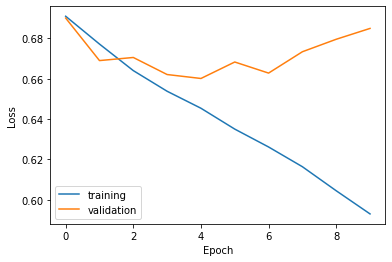

In [18]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

You can see this is a classic case of overfitting, with the validation data rising quickly as we improve our loss on the training data. Indeed, our model is quite expressive in its capability to fit the training data but it is incidentally fititng the noise. We have 61,000 trainable parameters and about 15,000 training examples, so this is not a surprise. However, we still able to learn a little bit – our accuracy is above 50%. This is actually a challenging dataset and the state-of-the art result is [77% accuracy](https://academic.oup.com/bioinformatics/article/34/15/2605/4938490?login=false). We need to expand our tools to include layers that can address overfitting.

## 4. Back propagation

At this stage, we should probably talk about back propagation and its connection to automatic gradient computation (autograds). This is how training “just works” when we take a gradient. This is actually a bit of a complicated topic, but it also nearly invisible to users of modern deep learning packages. Thus, I have chosen to not cover it in this book.

## 5. Regularization

As we saw in the ML chapters, regularization is a strategy that changes your training procedure (often by adding loss terms) to prevent overfitting. There is a nice argument for it in the bias-variance trade-off regarding model complexity, however this doesn’t seem to hold in practice. It is an empirical process that depends on many variables. Adding regularization if your model is underfit will usually reduce performance

### 5.1. Early Stopping

The most commonly used and simplest form of regularization is early stopping. Early stopping means monitoring the loss on your validation data and stopping training once it begins to rise. Normally, training is done until converged – meaning the loss stops decreasing. Early stopping tries to prevent overfitting by looking at the loss on unseen data (validation data) and stopping once that begins to rise. This is an example of regularization because the weights are limited to move a fixed distance from their initial value. Just like in L2 regularization, we’re squeezing our trainable weights. Early stopping can be a bit more complicated to implement in practice than it sounds, so check out how frameworks do it before trying to implement yourself (e.g., [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).

### 5.2. Weight

Weight regularization is the addition of terms to the loss that depend on the trainable weights in the solubility model example. These can be L2 or L1. You must choose the strength, which is expressed as a parameter (often denoted $\lambda$) that should be much less than 1. Typically values of 0.1 to 0.0001 are chosen. This may be broken into **kernel regularization**, which affects the multiplicative weights in a dense or convolution neural network, and **bias regularization**. Bias regularization is rarely seen in practice.